Welcome to an exercise where we will be replicating the discovery of the Z boson. We'll be making it easier for ourselves by using data from the Large Electron-Positron collider which was used to more precisely research properties of the Z bosons and can produce Z boson a lot better than the Super Proton Synchrotron which originally discovered it. The main problem with discovering the Z boson is the actual detection. Since Z bosons lifetime is very short it will decay into other particles, before we can detect it. One of the possible products of the decay can be 2 muons, which we can detect and will focus on. Here we will only use data of these double muons that come from Z particles. From the muons we can work backwards and calculate the mass of the particle that they decayed from. If we discover a lot of mass values that match the theoretical predictions of a Z boson, we have found it.

Start with the necessary imports and reading the datasets of github. The datasets can be combined using the `concat()` function:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import tracemalloc
import time

dataset91 = pd.read_csv('https://raw.githubusercontent.com/kraikisto/CERN_LEP_Z_boson/main/dimuon_short91_f1_000.csv.gz',index_col=False)
dataset92 = pd.read_csv('https://raw.githubusercontent.com/kraikisto/CERN_LEP_Z_boson/main/dimuon_short92_e2_000.csv.gz',index_col=False)
dataset93 = pd.read_csv('https://raw.githubusercontent.com/kraikisto/CERN_LEP_Z_boson/main/dimuon_short93_d2_000.csv.gz',index_col=False)
dataset94 = pd.read_csv('https://raw.githubusercontent.com/kraikisto/CERN_LEP_Z_boson/main/dimuon_short94_c2_000.csv.gz',index_col=False)
dataset = pd.concat([dataset91, dataset92, dataset93, dataset94])

22426


Z bosons decay is a relativistic process, so we can't solve its mass just by adding up the masses of the products, since some of the mass can turn into energy. We need to define a new definition of mass, which we can get from relativistic theory: Invariant mass. In particle physics it's commonly defined as 

$$
M c^2 = \dfrac{E^2}{c^2} - ||p||^2
$$


Because both energy and momentum are conserved, the invariant mass is also conserved and therefore we can calculate the invariant mass of the Z boson by calculating the invariant mass of the products. To calculate the combined invariant masses we can use the formula:

$$
Mc^2 = \sqrt{(E_1 + E_2)^2 - c^2 (\vec{p}_1 + \vec{p}_2)^2 }
$$

To simplify the calculations we can use natural units where $c=1$. If you just do this the program will give you a warning about negative values under the square root. Due to measurement error some values will infact be negative. Since they are caused by measurement error they are all quite small and will just be removed for now. 

If you try to do that, you'll first notice an error caused by mistakes in the data. After some tests you'll notice that there are some values of PZ1 with the value `**********`. First we remove those from the dataset and then change the datatype of the values to float64 since the values were saved as strings.

#### Exercise 1: Invariant mass

Your first job is to add a new column to the dataset with the invariant mass values. The before mentioned problems in the data have been fixed already, but the negative values still need to be removed. Use the equation above to calculate the mass values. The values from the dataset can be accessed simply by writing `dataset.E1` or other column name. The built in operations of pandas are generally recommended as they are optimised for speed and memory usage. If you want to learn more about this check out the extra material below:

<details>
<summary>Pandas performance comparison</summary>
Is pandas really faster? Well the answer is most of the time. A bunch of the more advanced python librabries like numpy and pandas use vectorisation the speed up their functions. In vectorisation, instead of running through the values one by one, we perform the same operation on a bunch of values saved as a vector. This is possible because of modern CPUs single instruction, multiple data (SIMD) processing. Traditionally processors could only hold one value and thus had to process one value at a time. Modern processors can hold multiple values and therefore run the same operation on a vector of values if you program it to do so. Let's now demonstrate this is a simple example comparing a columns of random data:

Let's use a simple example and compare the values from 2 columns in three different ways:

`df[fd.A != df.B]`  pandas using vectorisation

`df[[x != y for x, y in zip(df.A, df.B)]]` Using list comprehension, which is essentially a built-in optimised for-loop
    
A normal for-loop not optimised in any way

![alt text](https://raw.githubusercontent.com/kraikisto/CERN_LEP_Z_boson/main/comparison_alt.png)

We have plotted the measurements in logarithmic scale, but if you were to show them in linear scale, the lines would in fact be straight. A loop over a dataset does in fact always grow linearly in runtime and vectorisation doesn't change that, but it does significantly affect the slope of the graph. You can also notice that the basic for-loop is actually faster for small datasets, showing that you can't test functions just with small datasets and assume they behave the same way with bigger ones. Interestingly if we compare to another vectorised method from numpy we see that it is even faster. It seems that specifically `.values` is signifantly better than its pandas counterpart:

`df[df.A.values != df.B.values]` 

![alt text](https://raw.githubusercontent.com/kraikisto/CERN_LEP_Z_boson/main/pandasvnumpy.png)

Here it's clear that the slope of the graph is the same and rather the initial runtime is changed. Vectorisation isn't always even better. One example of this is flattening lists, meaning turning a list with multiple dimensions into a 1-dimensional list. This is most common with turning a matrix into a list. Here we'll compare `stack`function from pandas to list comprehension and to `chain`from the `itertools` python module. 

![alt text](https://raw.githubusercontent.com/kraikisto/CERN_LEP_Z_boson/main/list_flattening.png)

Notes: 

-Pandas code here is much easier to read than the for loop. 

-In pandas some functions don't use vectorisation. `iterrows()` and `apply()` both lose to list comprehension.

-I took the plotting code straight form the internet so if this gets officially used citing would probably be appropriate. 
Code used for plots: 

```python
#this uses perfplot, a tool specifically made for performance testing
import perfplot  
import pandas as pd
import numpy as np
from itertools import chain


def normal_loop(df):
    list1 = list(df.A)
    list2 = list(df.B)
    for i in range(0,len(list1)):
        if list1[i] == list2[i]:
            df = df.drop(index = i)
    return df

    

# Boolean indexing with float value comparison.
perfplot.show(
    setup=lambda n: pd.DataFrame(np.random.choice(1000, (n, 2)), columns=['A','B']),
    kernels=[
        lambda df: df[df.A != df.B],
        lambda df: df[[x != y for x, y in zip(df.A, df.B)]],
        lambda df: normal_loop(df),
    ],
    labels=['vectorised', 'list comp', "normal loop"],
    n_range=[2**k for k in range(5, 22)],
    xlabel='N', 
    logy=False, 
    logx=False
)


#pandas vs numpy
perfplot.show(
    setup=lambda n: pd.DataFrame(np.random.choice(1000, (n, 2)), columns=['A','B']),
    kernels=[
        lambda df: df[df.A != df.B],
        lambda df: df[df.A.values != df.B.values],

    ],
    labels=['pandas', 'numpy'],
    n_range=[2**k for k in range(0, 15)],
    xlabel='N', 
    logy=False, 
    logx=False
)


# Nested list flattening.
perfplot.show(
    setup=lambda n: pd.concat([pd.Series([['a', 'b', 'c'], [1, 2], []])] * n, ignore_index=True),
    kernels=[
        lambda ser: pd.DataFrame(ser.tolist()).stack().reset_index(drop=True),
        lambda ser: pd.Series(list(chain.from_iterable(ser.tolist()))),
        lambda ser: pd.Series([y for x in ser for y in x]),
    ],
    labels=['pandas.stack', 'itertools.chain', 'nested list comp'],
    n_range=[2**k for k in range(0, 15)],
    xlabel='N',    
    equality_check=None,
    logy=False,
    logx=False    
)
```


</details>


In [12]:
dataset = dataset[dataset.PZ1 != '**********'] #removes datapoints where PZ1 is **********
dataset = dataset.astype({'PZ1': 'float64'}) #convert the strings to floats for the upcoming calculations

#removing negative values:
dataset = dataset["add condition here"] #similarly as in the first line 

#calculating invariant mass:
dataset["M"] = 

#### Exercise 2: Histogram

Now let's plot the histogram of the invariant mass values. It can be done using `plt.his()` and adding in the data, number of bins `bins=` and the range `range=`. You will know that you have done it correctly if you see a spike around the mass of Z boson. Before the discovery of the Z boson, its mass could still be predicted at around 88 GeV using Weinberg-Salam theory and some experimental results for the coupling constants. 

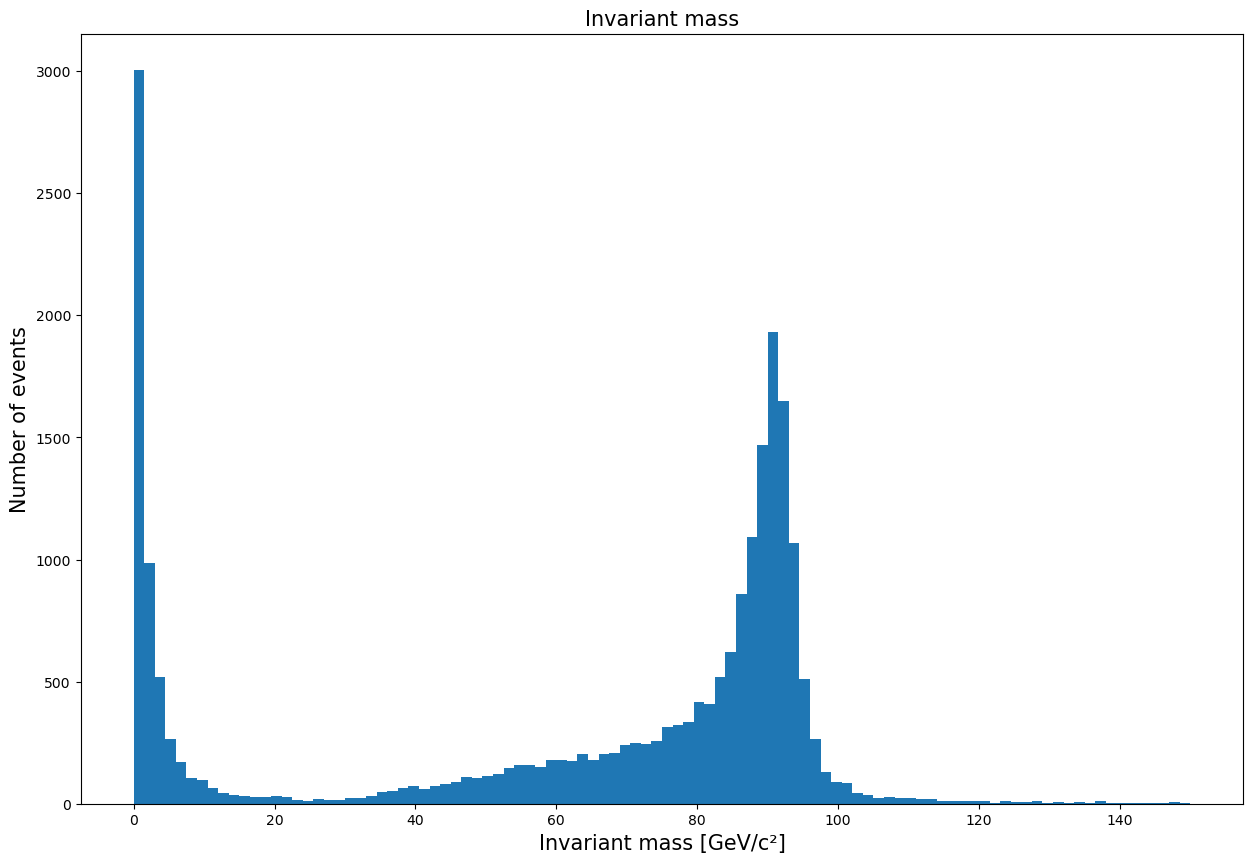

In [3]:
lowerlimit = 
upperlimit = 
bins = 

fig = plt.figure(figsize=(15, 10))
plt.hist("Add arguments here")

plt.xlabel('Invariant mass [GeV/c²]', fontsize=15)
plt.ylabel('Number of events', fontsize=15)
plt.title('Invariant mass', fontsize=15) 

plt.show()

Now that we have the histogram we can start analysing it. There is a peak (often called a resonance), which implies that we have been producing particles with that invariant mass. We can actually get even more from this histogram. This is done by plotting what is called a Breit-Wigner function on the histogram. Breit-Wigner distribution is commonly used to model unstable particles in high energy physics and is of the form:

$$
f(E) = \dfrac{k}{(E^2 - M^2)^2 + M^2 \Gamma^2} 
$$

where $k = \dfrac{2\sqrt{2}M \Gamma \gamma}{\pi\sqrt{M^2 + \gamma}}$ with $\gamma = \sqrt{M^2(M^2 + \Gamma^2)}$ which are in natural units $\hbar = c = 1$. $\Gamma$ is called the decay width or full width at half maximum and describes the width of the peak. 


Let's start with the simple parts of the fitting. First we limit ourselves to the area around where we know the particle is by setting limits to the mass values and remove the rest from the dataset. 

In [4]:
#limit to where Z-boson should be:
lowerlimit = 70
upperlimit = 100
bins = 50

#Create a histogram only around the peak
histogram = plt.hist(dataset.M, bins=bins, range=(lowerlimit,upperlimit), density = True) 
plt.close() #stop from showing the plot

#### Exercise 3: Fitting

In this exercise you will create the fit using `curve_fit()` from the `scipy.optimize` library. The arguments for it are: a function `f`, x-coordinates `xdata`, y-coordinates `ydata`, initial values `p0` and magnitude of uncertainty `sigma` which for us is $\sqrt{(y)}$. The values are mostly given to you, you will just have to add some of the initial values based on the previous histogram.





In [ ]:
from scipy.optimize import curve_fit

#Add initial guesses (3 are already given):
initials = [decay width, peak, 4, 2, 4]

def breitwigner(E, gamma, M, a, b, A):
    return a*E+b+A*( (2*np.sqrt(2)*M*gamma*np.sqrt(M**2*(M**2+gamma**2)))/(np.pi*np.sqrt(M**2+np.sqrt(M**2*(M**2+gamma**2)))) )/((E**2-M**2)**2+M**2*gamma**2)

#Histogram as an object consists of 2 lists: List of the heights of the bars and the edges of the bins
#Using normal list operations we can use the histogram to get x and y coordinates:
y = histogram[0] #gives the height of each bar in a list
x = 0.5*(histogram[1][0:-1] + histogram[1][1:]) #list of midpoints of a bins

#We save both the best values and the covariance from the fit
best, covariance = curve_fit("Add arguments here") 

Lastly we plot both this fitted function and the histogram into the same picture. We can also print the best values and their limits of error, which can be easily calculated from the covariance. 

The values and the uncertainties from the optimization:

The value of the decay width = 7.323538468469971 +- 0.41134665236863205
The value of the maximum of the distribution = 90.62100104021339 +- 0.1010846599817699
a = -0.0007495938628601569 +- 6.595053916894365e-05
b = 0.06438834759402297 +- 0.004911747202933199
A = 1.1498955158525361 +- 0.06062815859581237


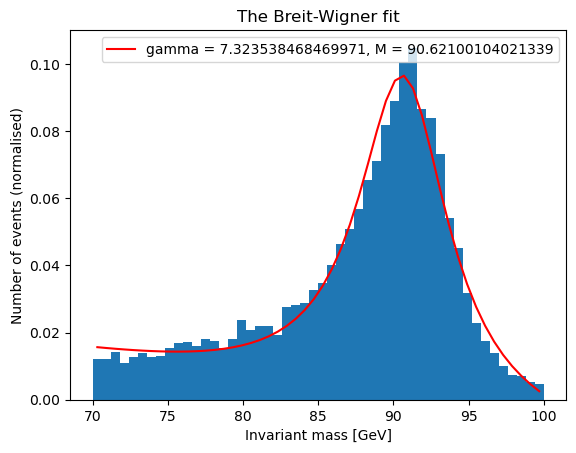

In [6]:
#Covariance is is determined using the sigma given. The diagonal elements are the variances.
error = np.sqrt(np.diag(covariance))
    
#Parameters and their errors from optimization:
print("The values and the uncertainties from the optimization:")
print("")
print("The value of the decay width = {} +- {}".format(best[0], error[0]))
print("The value of the maximum of the distribution = {} +- {}".format(best[1], error[1]))
print("a = {} +- {}".format(best[2], error[2]))
print("b = {} +- {}".format(best[3], error[3]))
print("A = {} +- {}".format(best[4], error[4]))

#plot both graphs:
plt.hist(dataset.M, bins=bins, range=(lowerlimit,upperlimit), density = True)
plt.plot(x, breitwigner(x, *best), 'r-', label='gamma = {}, M = {}'.format(best[0], best[1]))
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Number of events (normalised)')
plt.title('The Breit-Wigner fit')
plt.legend()
plt.show()

Well what do we get out of this? We got a more accurate estimation for the invariant mass of the Z boson. We also now know the value of gamma, which is the resonance width. It is also connected to mean lifetime of the particle which the resonance correlates to. The mean lifetime can be calculated from the formula:

$$
\Gamma = \dfrac{\hbar}{\tau}
$$

where $\hbar$ is the reduced Planck constant and $\tau$ the lifetime of the particle. 




In [ ]:
print("Mean lifetime is {} in the natural units".format(1/best[0]))

Our measurement for the invariant mass is still quite inaccurate. A large missing potential is a indicator that the datapoint may be inaccurate. Let's remove ones with a large missing potential and see if it makes the results more accurate:

#### Exercise 4: Missing potential

Here you will have to remove large missing potential from the dataset. You will have to experiment with the limit and see if you can improve the measurement of the Z boson mass. For this exercise it should be noted that the most accurate current measurements give it a mass of 91.1876. 

The values and the uncertainties from the optimization:

The value of the decay width = 6.272456092826122 +- 0.2207457790598211
The value of the maximum of the distribution = 90.80773054026123 +- 0.06236672052307315
a = -0.00048156370065822324 +- 3.88931601742655e-05
b = 0.03405816219673979 +- 0.0028081321130171226
A = 1.389837432763581 +- 0.04021891767260632


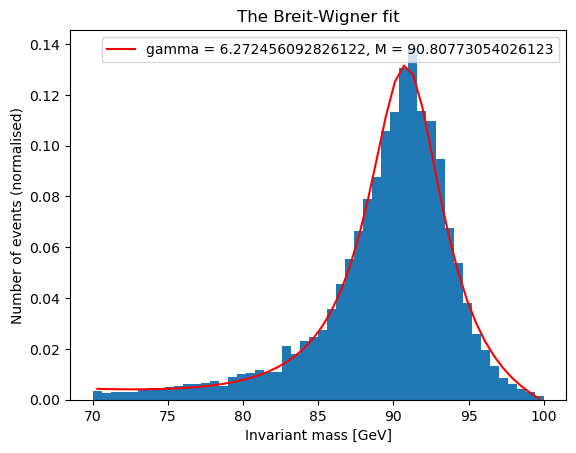

In [7]:
missing_pot_limit = 
limited_missing_pot = 
histogram = plt.hist(limited_missing_pot.M, bins=bins, range=(lowerlimit,upperlimit), density = True)


def breitwigner(E, gamma, M, a, b, A):
    return a*E+b+A*( (2*np.sqrt(2)*M*gamma*np.sqrt(M**2*(M**2+gamma**2)))/(np.pi*np.sqrt(M**2+np.sqrt(M**2*(M**2+gamma**2)))) )/((E**2-M**2)**2+M**2*gamma**2)

initials = [5, 90, 4, 2, 4]
y = histogram[0]
x = 0.5*(histogram[1][0:-1] + histogram[1][1:])
best, covariance = curve_fit(breitwigner, x, y, p0=initials, sigma=np.sqrt(y))
error = np.sqrt(np.diag(covariance))
    
print("The values and the uncertainties from the optimization:")
print("")
print("The value of the decay width = {} +- {}".format(best[0], error[0]))
print("The value of the maximum of the distribution = {} +- {}".format(best[1], error[1]))
print("a = {} +- {}".format(best[2], error[2]))
print("b = {} +- {}".format(best[3], error[3]))
print("A = {} +- {}".format(best[4], error[4]))

plt.plot(x, breitwigner(x, *best), 'r-', label='gamma = {}, M = {}'.format(best[0], best[1]))
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Number of events (normalised)')
plt.title('The Breit-Wigner fit')
plt.legend()
plt.show()

It does seem to actually be more accurate, although it didn't make a big difference. This method of plotting invariant masses isnt't quite the best method for this. Let's now look at something called line width fit: Here we will plot ECM values instead of invariant mass values. Therefore we get a histogram that shows how many datapoints (meaning particles) we produce at each ECM values. Since LEP only produces Z bosons, the amount of Z bosons goes up as we get closer to its invariant mass and we should be able to measure it very accurately.  

Since we are now relying on the number particles produced as a metric, the performace of the accelerator is also a variable. The performance of the accelerator can vary significantly and CERN measures it using a physical quantity called luminosity. Luminosity is defined as

$$
L = \dfrac{1}{\sigma} \dfrac{dN}{dt}
$$

meaning it is the rate of events divided by cross-section. Cross-section describes the probability of the colliding particles actually causing a reaction. Therefore integraded luminosity is just the total number of events divided by the cross-section.  

Here we will use integrated luminosity over the time that the accelerator run at a specific ECM. Since each center-of-mass energy (ECM) value has a different luminosity we need to find all ECM values and that can be done by using `.ECM.unique()` function on the dataset. From that we can see some values that are quite close to each other. This is because of noise in the measurement and can be fixed by setting the luminosity to all the ECM values less than 0.1 away from the exact value. Doing that we find that there are 7 different sections for ECM. Using the table given we can assing a luminosity to each datapoint in the dataset using `.loc`. The actual values for integrated luminosity can be found on papers published by CERN. 



In [ ]:
#section 1: 
lum1 = 711.1 #luminosity for this section
condition1 = np.abs(dataset91.ECM-88.5) < 0.1 #ECM for this section is near 88.5
dataset91.loc[condition1, "LUM"] = lum1 #set the luminosity under row "LUM"


#section 2: 
lum2 = 632.7
condition2 = np.abs(dataset91.ECM-89.5) < 0.1
dataset91.loc[condition2, "LUM"] = lum2


#section 3: 
lum3 = 622.6
condition3 = np.abs(dataset91.ECM-90.2) < 0.1
dataset91.loc[condition3 , "LUM"] = lum3


#section 4: 
lum4 = 2482.5
condition4 = np.abs(dataset91.ECM-91.2) < 0.1
dataset91.loc[condition4, "LUM"] = lum4


#section 5: 
lum5 = 666.1
condition5 = np.abs(dataset91.ECM-92) < 0.1
dataset91.loc[condition5, "LUM"] = lum5


#section 6: 
lum6 = 634.6
condition6 = np.abs(dataset91.ECM-93) < 0.1
dataset91.loc[condition6, "LUM"] = lum6


#section 7: 
lum7 = 681.2
condition7 = np.abs(dataset91.ECM-93.7) < 0.1
dataset91.loc[condition7, "LUM"] = lum7


There are actually a number of different ways to do this, some better than others. In the extra material below, we'll take a look at 2 of them, compare their time and space complexities. 

<details>
<summary>Time and space complexity</summary>
    
Let's define 2 programs that accomplish the same task in different ways. The first one is identical to what we did on the previous cell. 
    
```python

def first_program(dataset):
    #section 1: 
    lum1 = 711.1 #luminosity for this section
    condition1 = np.abs(dataset.ECM-88.5) < 0.1 #ECM for this section is near 88.5
    dataset.loc[condition1, "LUM"] = lum1 #set the luminosity under row "LUM"


    #section 2: 
    lum2 = 632.7
    condition2 = np.abs(dataset.ECM-89.5) < 0.1
    dataset.loc[condition2, "LUM"] = lum2


    #section 3: 
    lum3 = 622.6
    condition3 = np.abs(dataset.ECM-90.2) < 0.1
    dataset.loc[condition3 , "LUM"] = lum3


    #section 4: 
    lum4 = 2482.5
    condition4 = np.abs(dataset.ECM-91.2) < 0.1
    dataset.loc[condition4, "LUM"] = lum4


    #section 5: 
    lum5 = 666.1
    condition5 = np.abs(dataset.ECM-92) < 0.1
    dataset.loc[condition5, "LUM"] = lum5


    #section 6: 
    lum6 = 634.6
    condition6 = np.abs(dataset.ECM-93) < 0.1
    dataset.loc[condition6, "LUM"] = lum6


    #section 7: 
    lum7 = 681.2
    condition7 = np.abs(dataset.ECM-93.7) < 0.1
    dataset.loc[condition7, "LUM"] = lum7
    
    
    
def second_program(dataset):
    dataset_sorted = dataset.sort_values(by=["ECM"])
    dataset_sorted = dataset_sorted.reset_index(drop=True)
    unique_values = dataset_sorted.ECM.unique() #simulate having to print

    #section 1: 
    index1 = dataset_sorted[dataset_sorted.ECM == 89.506].index[0]
    lum1 = 711.1 #luminosity for this section
    dataset_sorted.loc[:index1, "LUM"] = lum1 #set the luminosity under row "LUM"


    #section 2: 
    lum2 = 632.7
    index2 = dataset_sorted[dataset_sorted.ECM == 90.256].index[0]
    dataset_sorted.loc[index1:index2, "LUM"] = lum2


    #section 3: 
    lum3 = 622.6
    index3 = dataset_sorted[dataset_sorted.ECM == 91.25].index[0]
    dataset_sorted.loc[index2:index3, "LUM"] = lum3


    #section 4: 
    lum4 = 2482.5
    index4 = dataset_sorted[dataset_sorted.ECM == 92.004].index[0]
    dataset_sorted.loc[index3:index4, "LUM"] = lum4


    #section 5: 
    lum5 = 666.1
    index5 = dataset_sorted[dataset_sorted.ECM == 93.015].index[0]
    dataset_sorted.loc[index4:index5, "LUM"] = lum5


    #section 6: 
    lum6 = 634.6
    index6 = dataset_sorted[dataset_sorted.ECM == 93.765].index[0]
    dataset_sorted.loc[index5:index6, "LUM"] = lum6


    #section 7: 
    lum7 = 681.2
    dataset_sorted.loc[index6:, "LUM"] = lum7
    return dataset_sorted

#measure first program in small dataset
start_time = time.time()
first_program(dataset91)
end_time = time.time()
result1 = end_time-start_time

#measure second program in small dataset
start_time = time.time()
second_program(dataset91)
end_time = time.time()
result2 = end_time-start_time

#measure first program in bigger dataset
start_time = time.time()
first_program(dataset)
end_time = time.time()
result3 = end_time-start_time

#measure second program in bigger dataset
start_time = time.time()
second_program(dataset)
end_time = time.time()
result4 = end_time-start_time
```
    
<br/>
    
**Question:** 

Before we look at the results, which one do you think does better? Why?
    
<details>
<summary>Results</summary>
    
First program with a small dataset: 0.018329620361328125
    
Second program with a small dataset: 0.016561031341552734
    
First program with a big dataset: 0.012064695358276367
    
Second program with a big dataset: 0.026291608810424805
</details>

<br/>

This isn't the most efficient method of testing the speed of an algorithm, since it just takes the real times and subtracts them. It does work for basic testing and is much easier to use than the one used previously to test vectorisation. 
    
So for the smaller dataset the first one is slower, but for the larger its always faster, why is this? Well lets look at the programs starting with the lines: 
    
`condition1 = np.abs(dataset.ECM-88.5) < 0.1` program one

`index1 = dataset[dataset.ECM == 89.478].index[0]` program two
    
Both are actually quite similar, running through the entire data checking the codition for each value. Let's say we have $N$ number of datapoints in our data. Then going through would take $aN$ time where $a$ is the amount of time it takes to go through one and is a constant. We usually denote this as $O(N)$ time complexity.  

For the next lines: 
    
`dataset.loc[condition1, "LUM"] = 711.1` program one

`dataset.loc[:index1, "LUM"] = 711.1` program two
    
Here program one is actually worse. It goes through the entire data checking the whether the condition is True or False just like the last lines we looked at. This is slower than actually giving the indices that need to be edited. Since program 2 goes through all datapoints once, instead of 7 times its 7 times faster. Both programs are still $O(N)$ complexity since both runtimes grow linearly in terms of $N$, one is just always 7 times slower. 

But now the reason why program 2 is worse on a large dataset: It has to sort the data first. There are a bunch of different sorting algorithms, but this uses quicksort as a default which is $O(N log N)$. This is larger than any of the other parts of the program so when the amount of data grows this will grow faster than all the other parts explaining why for a larger dataset the second program is always slower. 

The last 2 parts which are the resetting of indices and calculation of unique values are both $O(N)$ for the same reasons we covered before. Now the complexity of the entire program is just the largest term which is $O(N log N)$.

Now what about the memory usage? The tracemalloc library can be used to test the memory usage. Now when testing it is important to remember not to have anything already saved before for accurate measurements. The safest way to do that is to restart your kernel and run the first 2 cells to have everything you need imported and saved. After that you can run the cell below.    
    
```python
tracemalloc.start()
first_program(dataset)
print(tracemalloc.get_traced_memory())
tracemalloc.stop()

tracemalloc.start()
second_program(dataset)
print(tracemalloc.get_traced_memory())
tracemalloc.stop()
```

<br/>
    
**Question:**
    
Which one do you think does better? Why?
    
<details>
<summary>Results</summary>
    
First program: (10153, 573705)
    
Second program: (155310, 16483973)
    
The first value given is the current memory usage of the program and the second the peak memory usage. The peak is what matters here since that is what can stop your program from running. Now clearly the first program is the better one, but why? If we look at what variables we actually save, its quite obvious. In the beginning we save the entire dataset, sorted to a different order and then save the entire dataset again just with different indices.
    
</details>
    
<br/>
    
An easy way to make sure which part of the code is using too much memory is to compare just that part to the entire program.
    
```python
tracemalloc.start()
second_program(dataset)
print(tracemalloc.get_traced_memory())
tracemalloc.stop()

tracemalloc.start()
dataset_sorted = dataset.sort_values(["ECM"])
dataset_sorted = dataset_sorted.reset_index(drop=True)
print(tracemalloc.get_traced_memory())
tracemalloc.stop()
```
    
<br/>

(303154, 16630625)
    
(4457122, 16482811)

The peak is almost the same and current usage is ten times higher. This is clearly the main problem.
    
**Question:**
    
How would you improve the program?
    
<details>
<summary>Some improvements</summary>
    
```python
def second_program_improved(dataset):
    dataset.sort_values(by=["ECM"], inplace = True)
    dataset.reset_index(drop=True, inplace = True)
    unique_values = dataset.ECM.unique() #simulate having to print

    #section 1:
    lum1 = 711.1 #luminosity for this section
    index1 = dataset[dataset.ECM == 89.506].index[0]
    dataset.loc[:index1, "LUM"] = lum1 #set the luminosity under row "LUM"


    #section 2: 
    lum2 = 632.7
    index2 = dataset[dataset.ECM == 90.256].index[0]
    dataset.loc[index1:index2, "LUM"] = lum2


    #section 3: 
    lum3 = 622.6
    index3 = dataset[dataset.ECM == 91.25].index[0]
    dataset.loc[index2:index3, "LUM"] = lum3


    #section 4: 
    lum4 = 2482.5
    index4 = dataset[dataset.ECM == 92.004].index[0]
    dataset.loc[index3:index4, "LUM"] = lum4


    #section 5: 
    lum5 = 666.1
    index5 = dataset[dataset.ECM == 93.015].index[0]
    dataset.loc[index4:index5, "LUM"] = lum5


    #section 6: 
    lum6 = 634.6
    index6 = dataset[dataset.ECM == 93.765].index[0]
    dataset.loc[index5:index6, "LUM"] = lum6


    #section 7: 
    lum7 = 681.2
    dataset.loc[index6:, "LUM"] = lum7




tracemalloc.start()
second_program(dataset)
print(tracemalloc.get_traced_memory())
tracemalloc.stop()

tracemalloc.start()
second_program_improved(dataset)
print(tracemalloc.get_traced_memory())
tracemalloc.stop()
```
    
<br/>
    
(266297, 15801264)
    
(4647288, 12208766)
    
Copying the dataset over and over again is very inefficient. Here we just edit the dataset instead. It doesn't fix the problem of having to sort, which is often quite bad for memory, but does significantly improve the program. It's important to remember that now this function will change the dataset that we give it and sometimes this is not adviced. However, generally when dealing with large sets of data, it's recommended to edit the existing dataset instead of creating a copy to edit, unless you know that you will need the original again.
    
</details>
    
</details>

#### Exercise 5: Line-width fit

Now let's plot the histogram. Here you will have to find the correct range and number of bins to get the best possible graph for fitting. You want to have a graph with no empty bars as they can mess up the fit. You will also have to figure out how to correct for the luminosity. 

In [ ]:
lowerlimit = 
upperlimit =
bins=

#remember to correct for the luminosity
histogram = 



plt.xlabel('ECM', fontsize=15)
plt.ylabel('Number of events (normalised)', fontsize=15)
plt.title('Number of events of each ECM \n', fontsize=15) 
plt.show()

Now we fit the Breit-Wigner function just like before. This part you have done already once so just run the code normally. 

In [ ]:
initials = [1, 91, 1, 3, 1]
y = histogram[0]
x = 0.5*(histogram[1][0:-1] + histogram[1][1:])
best, covariance = curve_fit(breitwigner, x, y, p0=initials, sigma=np.sqrt(y)) 
error = np.sqrt(np.diag(covariance))

print("The values and the uncertainties from the optimization:")
print("")
print("The value of the decay width = {} +- {}".format(best[0], error[0])) 
print("The value of the maximum of the distribution = {} +- {}".format(best[1], error[1]))
print("a = {} +- {}".format(best[2], error[2]))
print("b = {} +- {}".format(best[3], error[3]))
print("A = {} +- {}".format(best[4], error[4]))

#For the smoother fit:
more_points = np.arange(lowerlimit,upperlimit, step=0.2)

plt.hist(dataset91.ECM, bins=bins, range=(lowerlimit,upperlimit), weights = 1/dataset91.LUM, density = True)
plt.plot(more_points, breitwigner(more_points, *best), 'r-', label='gamma = {}, M = {}'.format(best[0], best[1]))
plt.xlabel('ECM [GeV]')
plt.ylabel('Number of events (normalised)')
plt.title('The Breit-Wigner fit')
plt.legend()
plt.show()

Now let's compare to modern CMS data. We'll do the same steps as for the LEP data. 

The values and the uncertainties from the optimization:

The value of the decay width = 4.177200839163412 +- 0.15501257717258565
The value of the maximum of the distribution = 90.85095018949904 +- 0.04936129215048532
a = -0.00027224038908471164 +- 4.453412936672804e-05
b = 0.02361297095940811 +- 0.003389383968053174
A = 1.0759602426227084 +- 0.030646946842425294


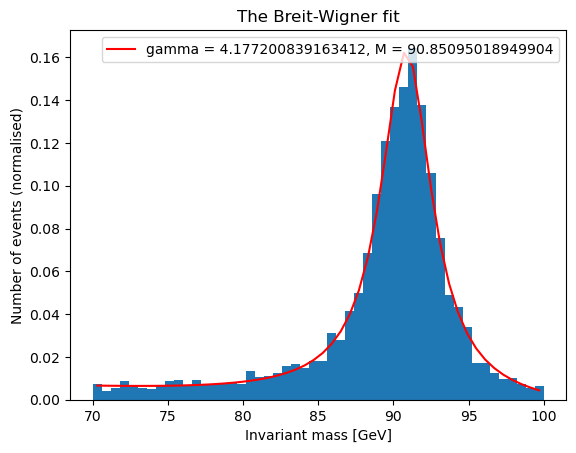

In [13]:
dataset_CMS = pd.read_csv('https://raw.githubusercontent.com/cms-opendata-education/cms-jupyter-materials-finnish/master/Data/Dimuon_DoubleMu.csv')
                        
lowerlimit = 70
upperlimit = 100
bins = 50

#Change the dataset to be only that area
limitedmasses_CMS = dataset_CMS[(dataset_CMS.M > lowerlimit) & (dataset_CMS.M < upperlimit)]
histogram = plt.hist(limitedmasses_CMS.M, bins=bins, range=(lowerlimit,upperlimit), density = True) 
plt.close() #stop from showing the plot

#Initial guesses:
initials = [5, 90, 4, 2, 4]
                      

#Histogram as an object consists of 2 lists: List of the heights of the bars and the edges of the bins
#Using normal list operations we can use the histogram to get x and y coordinates:
y = histogram[0] #gives the height of each bar in a list
x = 0.5*(histogram[1][0:-1] + histogram[1][1:]) #list of midpoints of a bins

#Fits the defined Breit-Wigner function to the (x,y) points gotten from the histogram
best, covariance = curve_fit(breitwigner, x, y, p0=initials, sigma=np.sqrt(y)) #sigma is the magnitude of the uncertainty in y-data
#Covariance is is determined using the sigma given. The diagonal elements are the variances.
error = np.sqrt(np.diag(covariance))
    
#Parameters and their errors from optimization:
print("The values and the uncertainties from the optimization:")
print("")
print("The value of the decay width = {} +- {}".format(best[0], error[0]))
print("The value of the maximum of the distribution = {} +- {}".format(best[1], error[1]))
print("a = {} +- {}".format(best[2], error[2]))
print("b = {} +- {}".format(best[3], error[3]))
print("A = {} +- {}".format(best[4], error[4]))

#plot both graphs:
plt.hist(limitedmasses_CMS.M, bins=bins, range=(lowerlimit,upperlimit), density = True)
plt.plot(x, breitwigner(x, *best), 'r-', label='gamma = {}, M = {}'.format(best[0], best[1]))
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Number of events (normalised)')
plt.title('The Breit-Wigner fit')
plt.legend()
plt.show()

**Question:**

Which one is better? Why is it better?

<details>
<summary>Answers</summary>  
If you look at the results and compare them to the mass you can find on google you can see that LEP is closer to the correct result. The LHC, or hadron colliders altogether aren't as good at measuring the mass of the Z boson as LEP was. LEP produces only Z bosons, whereas LHC produces all kinds of particles. Electron-positron colliders are simply better at some tasks, which is why CERN is actually planning on making a new electron-positron collider as the next circular collider. 
</details>     

</br>

We can actually make the CMS data more accurate using pseudorapidities. Pseudorapidity is a quantity that describes the angle of the detected particle. Its infinite when the particle goes to the direction of the beam pipe and zero if the particle goes directly at the wall of the beam pipe. Obviously, going straight to the wall and to the detector is better for the measurement as we have less noise.

#### Exercise 6: Pseudorapidity

Remove bad measurements by choosing a which pseudorapidities to keep. You may also have to alter the histogram to account fot the smaller number of datapoints. See how close you can get to the actual value.

The values and the uncertainties from the optimization:

The value of the decay width = 4.365579433508856 +- 0.2502612280554318
The value of the maximum of the distribution = 90.93273520568478 +- 0.0781241499456182
a = -0.00024564721209831183 +- 7.010950261305277e-05
b = 0.019819630018284188 +- 0.00522981575600549
A = 1.1129027529664794 +- 0.04992721719553382


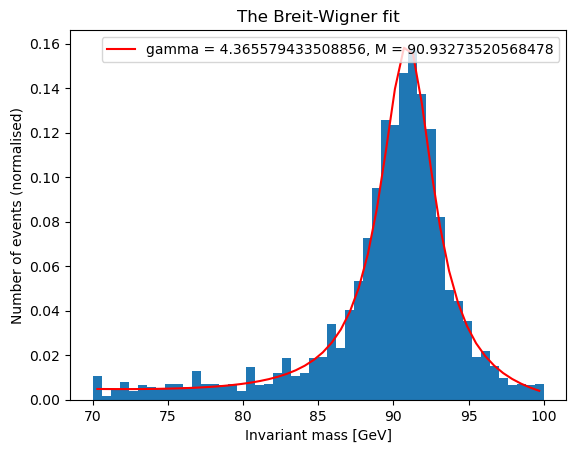

In [15]:
bins= 
lowerlimit = 
upperlimit = 
small_etas = dataset_CMS[(np.absolute(dataset_CMS.eta1) "add inequality") & (np.absolute(dataset_CMS.eta2) "add inequality")]
histogram = plt.hist(small_etas.M, bins=bins, range=(lowerlimit,upperlimit), density = True) 
plt.close() 
initials = [5, 90, 4, 2, 4]
                      
y = histogram[0] 
x = 0.5*(histogram[1][0:-1] + histogram[1][1:]) 

best, covariance = curve_fit(breitwigner, x, y, p0=initials, sigma=np.sqrt(y)) 
error = np.sqrt(np.diag(covariance))
    
print("The values and the uncertainties from the optimization:")
print("")
print("The value of the decay width = {} +- {}".format(best[0], error[0]))
print("The value of the maximum of the distribution = {} +- {}".format(best[1], error[1]))
print("a = {} +- {}".format(best[2], error[2]))
print("b = {} +- {}".format(best[3], error[3]))
print("A = {} +- {}".format(best[4], error[4]))

plt.hist(small_etas.M, bins=bins, range=(lowerlimit,upperlimit), density = True)
plt.plot(x, breitwigner(x, *best), 'r-', label='gamma = {}, M = {}'.format(best[0], best[1]))
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Number of events (normalised)')
plt.title('The Breit-Wigner fit')
plt.legend()
plt.show()